# PCGL Submission Workflow Performance Analysis

This notebook analyzes Nextflow trace reports to provide comprehensive performance insights for PCGL molecular data submission workflow across different file sizes, execution modes, and locations.

## Usage Instructions

### Quick Start
1. **Update the input directory path** in the "Data Loading and Processing" section to point to your `trace_report` directory
2. **Run all cells** to generate the complete performance analysis with location, execution mode and file size based aggregation
3. **View generated plots** in the `analysis_plots` directory

### Expected Input Structure
```
tests/performance/trace_file/
├── oicr/
│   ├── u001/
│   │   ├── trace_sequential_20G.txt
│   │   ├── trace_parallel_39G.txt
│   │   └── trace_mixed_97G.txt
│   └── u002/
│       ├── trace_sequential_194G.txt
│       └── trace_parallel_388G.txt
└── c3g/
    └── u001/
        ├── trace_sequential_97G.txt
        └── trace_mixed_194G.txt
```

### Generated Outputs 
- **Key Module Execution Times**: Execution time analysis for key modules: `score_upload` and `validation_crosscheck` in minutes with error bars showing variability
- **Key Module Process Rates**: Throughput analysis for key modules: `score_upload` and `validation_crosscheck` in GB/minute with error bars showing variability
- **Job Duration Analysis**: Individual job completion times with standard deviation error bars in minutes
- **Queue Wait Times**: Resource contention analysis in seconds


### Customization Options
- Modify `input_dir` variable to change the source directory (default: `../trace_file`)
- Adjust `output_dir` to save plots to a different location (default: `../analysis_plots`)


In [14]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully")

Libraries imported successfully


## Configuration and Helper Functions

In [15]:
def extract_file_info(trace_file_path):
    """Extract file size, execution mode, location, and user from trace file path."""
    # Extract from filename pattern: trace_{execution_mode}_{file_size}.txt
    filename = Path(trace_file_path).name
    
    # Parse filename: trace_{execution_mode}_{file_size}G.txt
    filename_match = re.match(r'trace_([^_]+)_(\d+)G\.txt', filename)
    if filename_match:
        execution_mode = filename_match.group(1).title()  # Sequential, Parallel, Mixed
        file_size_gb = int(filename_match.group(2))  # Extract numeric part (20, 39, 97, etc.)
        file_size = f"{file_size_gb}GB"  # Format as 20GB, 39GB, etc.
    else:
        execution_mode = "Unknown"
        file_size = "Unknown"
        file_size_gb = 0
    
    # Extract location and user from path: .../trace_file/{location}/{user}/
    path_parts = Path(trace_file_path).parts
    if 'trace_file' in path_parts:
        trace_idx = path_parts.index('trace_file')
        if len(path_parts) > trace_idx + 2:
            location = path_parts[trace_idx + 1]
            user = path_parts[trace_idx + 2]
        else:
            location = "Unknown"
            user = "Unknown"
    else:
        location = "Unknown"
        user = "Unknown"
    
    return file_size, file_size_gb, execution_mode, location, user

print("Helper functions defined successfully")

Helper functions defined successfully


## Data Loading and Processing

In [16]:
# Configure input directory and output directory
input_dir = Path("../trace_file").resolve()  # Path to trace_file directory (absolute path)
output_dir = Path("../analysis_plots").resolve()
output_dir.mkdir(parents=True, exist_ok=True)

def load_trace_files(directory):
    """Load all trace files with pattern trace_{execution_mode}_{file_size}.txt."""
    print(f"Searching for trace files in: {directory}")
    print(f"Directory exists: {directory.exists()}")
    print(f"Directory is dir: {directory.is_dir()}")
    
    trace_files = list(directory.glob("**/trace_*.txt"))
    
    if not trace_files:
        print(f"No trace_*.txt files found in {directory}")
        print(f"Trying to list subdirectories...")
        if directory.exists() and directory.is_dir():
            for item in directory.iterdir():
                print(f"  Found: {item.name} ({'dir' if item.is_dir() else 'file'})")
        return []
    
    print(f"Found {len(trace_files)} trace files")
    return trace_files

def process_trace_file(trace_file):
    """Process a single trace file and extract performance metrics."""
    try:
        # Read the trace file
        df = pd.read_csv(trace_file, sep='\t')
        
        # Extract file info from path
        file_size, file_size_gb, execution_mode, location, user = extract_file_info(trace_file)
        
        # Ensure numeric columns are properly typed (trace files contain raw values)
        numeric_cols = ['realtime', 'queue', 'rss', 'vmem', 'read_bytes', 'write_bytes', 'submit', 'start', 'complete']
        for col in numeric_cols:
            if col in df.columns:
                # Handle queue field specifically (often contains "-")
                if col == 'queue':
                    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
                else:
                    # Convert to numeric, replacing any non-numeric values with 0
                    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
        
        # Calculate estimated queue wait time using submit/start timestamps if available
        if 'submit' in df.columns and 'start' in df.columns:
            # Estimated queue wait = start - submit (in milliseconds)
            df['estimated_queue_wait_ms'] = df['start'] - df['submit']
            # Ensure non-negative values (sometimes start can be before submit in logs)
            df['estimated_queue_wait_ms'] = df['estimated_queue_wait_ms'].clip(lower=0)
        else:
            df['estimated_queue_wait_ms'] = 0
        
        # Add metadata
        df['file_size'] = file_size
        df['file_size_gb'] = file_size_gb
        df['execution_mode'] = execution_mode
        df['location'] = location
        df['user'] = user
        df['trace_file'] = str(trace_file)
        
        return df
        
    except Exception as e:
        print(f"Error processing {trace_file}: {e}")
        return None

# Load and process all trace files
trace_files = load_trace_files(input_dir)
all_data = []

for trace_file in trace_files:
    processed_data = process_trace_file(trace_file)
    if processed_data is not None:
        all_data.append(processed_data)

if all_data:
    # Combine all data
    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"Combined dataset shape: {combined_df.shape}")
    print(f"File sizes: {sorted(combined_df['file_size'].unique())}")
    print(f"Execution modes: {sorted(combined_df['execution_mode'].unique())}")
    print(f"Locations: {sorted(combined_df['location'].unique())}")
    print(f"Users: {sorted(combined_df['user'].unique())}")
    
    # Show aggregation summary
    summary = combined_df.groupby(['location', 'execution_mode', 'file_size']).agg({
        'trace_file': 'nunique'
    }).rename(columns={'trace_file': 'num_files'})
    print(f"\nAggregation summary (by location, execution mode, file size):")
    print(summary)
else:
    print("No data was successfully processed")
    combined_df = pd.DataFrame()

Searching for trace files in: /Users/lxiang/Projects/PCGL/molecular-data-submission-workflow/tests/performance/trace_file
Directory exists: True
Directory is dir: True
Found 11 trace files
Combined dataset shape: (1671, 42)
File sizes: ['194GB', '20GB', '388GB', '39GB', '97GB']
Execution modes: ['Parallel', 'Sequential']
Locations: ['c3g', 'oicr']
Users: ['u001']

Aggregation summary (by location, execution mode, file size):
                                   num_files
location execution_mode file_size           
c3g      Sequential     20GB               1
oicr     Parallel       194GB              1
                        20GB               1
                        388GB              1
                        39GB               1
                        97GB               1
         Sequential     194GB              1
                        20GB               1
                        388GB              1
                        39GB               1
                        97GB   

## Performance Metrics Calculation

In [17]:
def calculate_performance_metrics(df):
    """Calculate comprehensive performance metrics aggregated by location, execution mode, and file size."""
    if df.empty:
        return {}, {}, {}
    
    # 1. Process-level metrics (aggregated across users within same location)
    process_metrics = []
    
    for (location, file_size, execution_mode, process_name), group in df.groupby(['location', 'file_size', 'execution_mode', 'process']):
        if 'realtime' in group.columns:
            metrics = {
                'location': location,
                'file_size': file_size,
                'execution_mode': execution_mode,
                'process_name': process_name,
                'avg_execution_time_ms': group['realtime'].mean(),
                'median_execution_time_ms': group['realtime'].median(),
                'std_execution_time_ms': group['realtime'].std(),
                'avg_queue_wait_ms': group.get('estimated_queue_wait_ms', pd.Series([0])).mean(),
                'median_queue_wait_ms': group.get('estimated_queue_wait_ms', pd.Series([0])).median(),
                'std_queue_wait_ms': group.get('estimated_queue_wait_ms', pd.Series([0])).std(),
                'task_count': len(group)
            }
            
            # Calculate process rate (GB per minute) for relevant processes
            if group['file_size_gb'].iloc[0] > 0 and metrics['avg_execution_time_ms'] > 0:
                # Convert execution time from ms to minutes for each task
                task_execution_times_minutes = group['realtime'] / (1000 * 60)
                # Calculate individual process rates for each task
                task_process_rates = group['file_size_gb'].iloc[0] / task_execution_times_minutes
                # Filter out infinite/invalid rates
                valid_rates = task_process_rates[task_process_rates.notna() & (task_process_rates != float('inf'))]
                
                if len(valid_rates) > 0:
                    metrics['process_rate_gb_per_minute'] = valid_rates.mean()
                    metrics['std_process_rate_gb_per_minute'] = valid_rates.std()
                else:
                    metrics['process_rate_gb_per_minute'] = 0
                    metrics['std_process_rate_gb_per_minute'] = 0
            else:
                metrics['process_rate_gb_per_minute'] = 0
                metrics['std_process_rate_gb_per_minute'] = 0
            
            process_metrics.append(metrics)
    
    process_metrics_df = pd.DataFrame(process_metrics)
    
    # 2. Job-level metrics (using tag field to group tasks into jobs)
    job_metrics = []
    
    # Add job_id extraction from tag field
    def extract_job_id(tag):
        """Extract job_id from tag field with pattern {job_id}:{other_part}"""
        if pd.isna(tag) or tag == '-':
            return None
        
        # Split by colon and take the first part as job_id
        parts = str(tag).split(':')
        if len(parts) > 0:
            job_id = parts[0]
            # Validate job_id pattern: analysis_{file_size}G_{3_digits}
            if re.match(r'analysis_\d+G_\d{3}', job_id):
                return job_id
        return None
    
    # Extract job_id from tag for all rows
    df['job_id'] = df.get('tag', pd.Series(dtype='object')).apply(extract_job_id)

    for (location, file_size, execution_mode, user), user_group in df.groupby(['location', 'file_size', 'execution_mode', 'user']):
        # Group by job_id to get individual job durations within each user's batch
        valid_jobs = user_group[user_group['job_id'].notna()]
        if not valid_jobs.empty:
            for job_id, job_group in valid_jobs.groupby('job_id'):
                job_duration_ms = job_group['realtime'].sum()
                
                job_metric = {
                    'location': location,
                    'file_size': file_size,
                    'execution_mode': execution_mode,
                    'user': user,
                    'job_id': job_id,
                    'job_duration_ms': job_duration_ms,
                    'task_count': len(job_group),
                    'avg_task_duration_ms': job_group['realtime'].mean(),
                    'total_queue_time_ms': job_group.get('estimated_queue_wait_ms', pd.Series([0])).sum(),
                    'avg_queue_wait_ms': job_group.get('estimated_queue_wait_ms', pd.Series([0])).mean()
                }
                job_metrics.append(job_metric)
    
    job_metrics_df = pd.DataFrame(job_metrics)
    
    # Aggregate job metrics by location, file_size, execution_mode
    job_summary = []
    if not job_metrics_df.empty:
        for (location, file_size, execution_mode), group in job_metrics_df.groupby(['location', 'file_size', 'execution_mode']):
            summary = {
                'location': location,
                'file_size': file_size,
                'execution_mode': execution_mode,
                'avg_job_duration_ms': group['job_duration_ms'].mean(),
                'median_job_duration_ms': group['job_duration_ms'].median(),
                'std_job_duration_ms': group['job_duration_ms'].std(),
                'min_job_duration_ms': group['job_duration_ms'].min(),
                'max_job_duration_ms': group['job_duration_ms'].max(),
                'job_count': len(group),
                'user_count': group['user'].nunique(),
                'avg_tasks_per_job': group['task_count'].mean()
            }
            job_summary.append(summary)
    
    job_summary_df = pd.DataFrame(job_summary)
    
    # 3. Queue wait time metrics (resource contention analysis aggregated by location)
    queue_metrics = []
    
    for (location, file_size, execution_mode), group in df.groupby(['location', 'file_size', 'execution_mode']):
        if 'estimated_queue_wait_ms' in group.columns:
            metrics = {
                'location': location,
                'file_size': file_size,
                'execution_mode': execution_mode,
                'avg_queue_wait_ms': group['estimated_queue_wait_ms'].mean(),
                'median_queue_wait_ms': group['estimated_queue_wait_ms'].median(),
                'std_queue_wait_ms': group['estimated_queue_wait_ms'].std(),
                'max_queue_wait_ms': group['estimated_queue_wait_ms'].max(),
                'total_queue_time_ms': group['estimated_queue_wait_ms'].sum(),
                'tasks_with_queue_wait': (group['estimated_queue_wait_ms'] > 0).sum(),
                'total_tasks': len(group),
                'avg_submit_to_start_ms': group['estimated_queue_wait_ms'].mean(),  # More descriptive name
                'queue_estimation_method': 'submit_to_start_gap'  # Document the method used
            }
            
            # Calculate queue wait percentage
            if metrics['total_tasks'] > 0:
                metrics['queue_wait_percentage'] = (metrics['tasks_with_queue_wait'] / metrics['total_tasks']) * 100
            else:
                metrics['queue_wait_percentage'] = 0
            
            queue_metrics.append(metrics)
    
    queue_metrics_df = pd.DataFrame(queue_metrics)
    
    return process_metrics_df, job_summary_df, queue_metrics_df

# Calculate all performance metrics
if not combined_df.empty:
    process_metrics, job_metrics, queue_metrics = calculate_performance_metrics(combined_df)
    
    print("Performance metrics calculated:")
    print(f"- Process metrics: {len(process_metrics)} records")
    print(f"- Job metrics: {len(job_metrics)} records")
    print(f"- Queue metrics: {len(queue_metrics)} records")
else:
    process_metrics = pd.DataFrame()
    job_metrics = pd.DataFrame()
    queue_metrics = pd.DataFrame()
    print("No data available for metrics calculation")

Performance metrics calculated:
- Process metrics: 176 records
- Job metrics: 11 records
- Queue metrics: 11 records


## Visualization Functions

In [18]:
def create_comparison_plots(process_metrics, job_metrics, queue_metrics, output_dir):
    """Create comparison plots with consolidated location comparison and consistent colors."""
    
    # Define consistent ordering for execution modes and file sizes
    mode_order = ['Sequential', 'Parallel', 'Mixed']
    file_size_order = ['20GB', '39GB', '97GB', '194GB', '388GB']
    key_processes = ['score_upload', 'validation_crosscheck']
    
    # Set up the plotting style
    plt.rcParams.update({'font.size': 10, 'figure.dpi': 100})
    
    # Get unique locations for consolidated comparison
    locations = sorted(process_metrics['location'].unique()) if not process_metrics.empty else []
    
    # Create a centralized color mapping function for consistency across all plots
    def create_consistent_color_map(data_df):
        """Create a consistent color map for location-mode combinations."""
        import matplotlib.cm as cm
        import numpy as np
        
        if data_df.empty:
            return {}
        
        # Get all unique location-mode combinations across all data
        unique_locations = sorted(data_df['location'].unique())
        unique_modes = sorted(data_df['execution_mode'].unique())
        
        # Use a consistent color palette that works well for grouped bars
        colors = cm.tab20(np.linspace(0, 1, len(unique_locations) * len(unique_modes)))
        
        color_map = {}
        color_idx = 0
        for location in unique_locations:
            for mode in unique_modes:
                color_map[f"{location}_{mode}"] = colors[color_idx]
                color_idx += 1
        
        return color_map
    
    # Plot 1: Key Process Execution Times (Consolidated across locations)
    if not process_metrics.empty:
        # Create consolidated plots for each key process category
        for process_name in key_processes:
            # Check if there's any data for this process category across all locations
            category_data = process_metrics[
                process_metrics['process_name'].str.lower().str.contains(process_name, na=False)
            ]
            
            if category_data.empty:
                print(f"Skipping {process_name} plot - no data available")
                continue
            
            # Convert to minutes for better readability
            category_data = category_data.copy()
            category_data['avg_execution_time_minutes'] = category_data['avg_execution_time_ms'] / (1000 * 60)
            category_data['std_execution_time_minutes'] = category_data['std_execution_time_ms'] / (1000 * 60)
            
            # Create a consolidated plot
            fig, ax = plt.subplots(1, 1, figsize=(16, 8))
            
            # Group by location, file_size, and execution_mode
            process_summary = category_data.groupby(['location', 'file_size', 'execution_mode']).agg({
                'avg_execution_time_minutes': 'mean',
                'std_execution_time_minutes': 'mean'
            }).reset_index()
            
            # Create a combined label for location + execution mode
            process_summary['location_mode'] = process_summary['location'] + '_' + process_summary['execution_mode']
            
            # Use consistent color mapping
            color_map = create_consistent_color_map(process_summary)
            
            # Create pivot table for plotting
            pivot_data = process_summary.pivot(index='file_size', columns='location_mode', values='avg_execution_time_minutes')
            pivot_std = process_summary.pivot(index='file_size', columns='location_mode', values='std_execution_time_minutes')
            
            # Reindex with consistent file size ordering
            pivot_data = pivot_data.reindex(index=[size for size in file_size_order if size in pivot_data.index])
            pivot_std = pivot_std.reindex(index=pivot_data.index)
            
            # Create grouped bar plot
            pivot_data.plot(kind='bar', ax=ax, width=0.8, yerr=pivot_std, capsize=3, 
                          color=[color_map.get(col, 'gray') for col in pivot_data.columns])
            
            ax.set_title(f'{process_name.replace("_", " ").title()} Module Execution Time', 
                        fontsize=14, fontweight='bold')
            ax.set_xlabel('File Size', fontsize=12)
            ax.set_ylabel('Execution Time (minutes)', fontsize=12)
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)
            
            # Improve legend
            ax.legend(title='Location_ExecutionMode', bbox_to_anchor=(1.05, 1), loc='upper left')
            
            plt.tight_layout()
            plot_path = output_dir / f'{process_name}_execution_times_consolidated.png'
            plt.savefig(plot_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {plot_path}")
            plt.show()
    
    # Plot 2: Process Rates (Consolidated across locations)
    if not process_metrics.empty and 'process_rate_gb_per_minute' in process_metrics.columns:
        # Create consolidated plots for each key process category
        for process_name in key_processes:
            # Check if there's any data for this process category across all locations
            category_data = process_metrics[
                (process_metrics['process_rate_gb_per_minute'] > 0) &
                (process_metrics['process_name'].str.lower().str.contains(process_name, na=False))
            ]
            
            if category_data.empty:
                print(f"Skipping {process_name} process rate plot - no data available")
                continue
            
            # Create a consolidated plot
            fig, ax = plt.subplots(1, 1, figsize=(16, 8))
            
            # Group by location, file_size, and execution_mode
            rate_summary = category_data.groupby(['location', 'file_size', 'execution_mode']).agg({
                'process_rate_gb_per_minute': 'mean',
                'std_process_rate_gb_per_minute': 'mean'
            }).reset_index()
            
            # Create a combined label for location + execution mode
            rate_summary['location_mode'] = rate_summary['location'] + '_' + rate_summary['execution_mode']
            
            # Use consistent color mapping
            color_map = create_consistent_color_map(rate_summary)
            
            # Create pivot table for plotting
            pivot_rate = rate_summary.pivot(index='file_size', columns='location_mode', values='process_rate_gb_per_minute')
            pivot_rate_std = rate_summary.pivot(index='file_size', columns='location_mode', values='std_process_rate_gb_per_minute')
            
            # Reindex with consistent file size ordering
            pivot_rate = pivot_rate.reindex(index=[size for size in file_size_order if size in pivot_rate.index])
            pivot_rate_std = pivot_rate_std.reindex(index=pivot_rate.index)
            
            # Create grouped bar plot
            pivot_rate.plot(kind='bar', ax=ax, width=0.8, yerr=pivot_rate_std, capsize=3,
                          color=[color_map.get(col, 'gray') for col in pivot_rate.columns])
            
            ax.set_title(f'{process_name.replace("_", " ").title()} Process Rate', 
                        fontsize=14, fontweight='bold')
            ax.set_xlabel('File Size', fontsize=12)
            ax.set_ylabel('Process Rate (GB/minute)', fontsize=12)
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)
            
            # Improve legend
            ax.legend(title='Location_ExecutionMode', bbox_to_anchor=(1.05, 1), loc='upper left')
            
            plt.tight_layout()
            plot_path = output_dir / f'{process_name}_process_rates_consolidated.png'
            plt.savefig(plot_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {plot_path}")
            plt.show()
    
    # Plot 3: Job Duration Analysis (Consolidated across locations)
    if not job_metrics.empty:
        # Convert to minutes for better readability
        job_data = job_metrics.copy()
        job_data['avg_job_duration_minutes'] = job_data['avg_job_duration_ms'] / (1000 * 60)
        job_data['std_job_duration_minutes'] = job_data['std_job_duration_ms'] / (1000 * 60)
        
        # Create a consolidated plot
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))
        
        # Create a combined label for location + execution mode
        job_data['location_mode'] = job_data['location'] + '_' + job_data['execution_mode']
        
        # Use consistent color mapping
        color_map = create_consistent_color_map(job_data)
        
        # Create pivot tables for mean and std
        pivot_duration = job_data.pivot(index='file_size', columns='location_mode', values='avg_job_duration_minutes')
        pivot_std = job_data.pivot(index='file_size', columns='location_mode', values='std_job_duration_minutes')
        
        # Reindex with consistent ordering
        pivot_duration = pivot_duration.reindex(index=[size for size in file_size_order if size in pivot_duration.index])
        pivot_std = pivot_std.reindex(index=pivot_duration.index)
        
        # Create grouped bar plot with error bars
        pivot_duration.plot(kind='bar', ax=ax, width=0.8, yerr=pivot_std, capsize=3,
                          color=[color_map.get(col, 'gray') for col in pivot_duration.columns])
        
        ax.set_title('Job Duration - All Locations', fontsize=14, fontweight='bold')
        ax.set_xlabel('File Size', fontsize=12)
        ax.set_ylabel('Job Duration (minutes)', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        
        # Improve legend
        ax.legend(title='Location_ExecutionMode', bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plot_path = output_dir / 'job_duration_consolidated.png'
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {plot_path}")
        plt.show()
    
    # Plot 4: Queue Wait Time Analysis (Consolidated across locations)
    if not queue_metrics.empty:
        # Convert to seconds for better readability
        queue_data = queue_metrics.copy()
        queue_data['avg_queue_wait_seconds'] = queue_data['avg_queue_wait_ms'] / 1000
        queue_data['std_queue_wait_seconds'] = queue_data['std_queue_wait_ms'] / 1000
        
        # Create a consolidated plot
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))
        
        # Create a combined label for location + execution mode
        queue_data['location_mode'] = queue_data['location'] + '_' + queue_data['execution_mode']
        
        # Use consistent color mapping
        color_map = create_consistent_color_map(queue_data)
        
        # Create pivot tables for queue wait times (mean and std)
        pivot_queue = queue_data.pivot(index='file_size', columns='location_mode', values='avg_queue_wait_seconds')
        pivot_queue_std = queue_data.pivot(index='file_size', columns='location_mode', values='std_queue_wait_seconds')
        
        # Reindex with consistent ordering
        pivot_queue = pivot_queue.reindex(index=[size for size in file_size_order if size in pivot_queue.index])
        pivot_queue_std = pivot_queue_std.reindex(index=pivot_queue.index)
        
        # Create grouped bar plot with error bars
        pivot_queue.plot(kind='bar', ax=ax, width=0.8, yerr=pivot_queue_std, capsize=3,
                        color=[color_map.get(col, 'gray') for col in pivot_queue.columns])
        
        ax.set_title('Queue Wait Time', fontsize=14, fontweight='bold')
        ax.set_xlabel('File Size', fontsize=12)
        ax.set_ylabel('Queue Wait Time (seconds)', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        
        # Improve legend
        ax.legend(title='Location_ExecutionMode', bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plot_path = output_dir / 'queue_wait_times_consolidated.png'
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {plot_path}")
        plt.show()

print("Visualization functions defined successfully")

Visualization functions defined successfully


## Generate Performance Analysis Plots

Generating performance comparison plots...
Saved: /Users/lxiang/Projects/PCGL/molecular-data-submission-workflow/tests/performance/analysis_plots/score_upload_execution_times_consolidated.png
Saved: /Users/lxiang/Projects/PCGL/molecular-data-submission-workflow/tests/performance/analysis_plots/score_upload_execution_times_consolidated.png


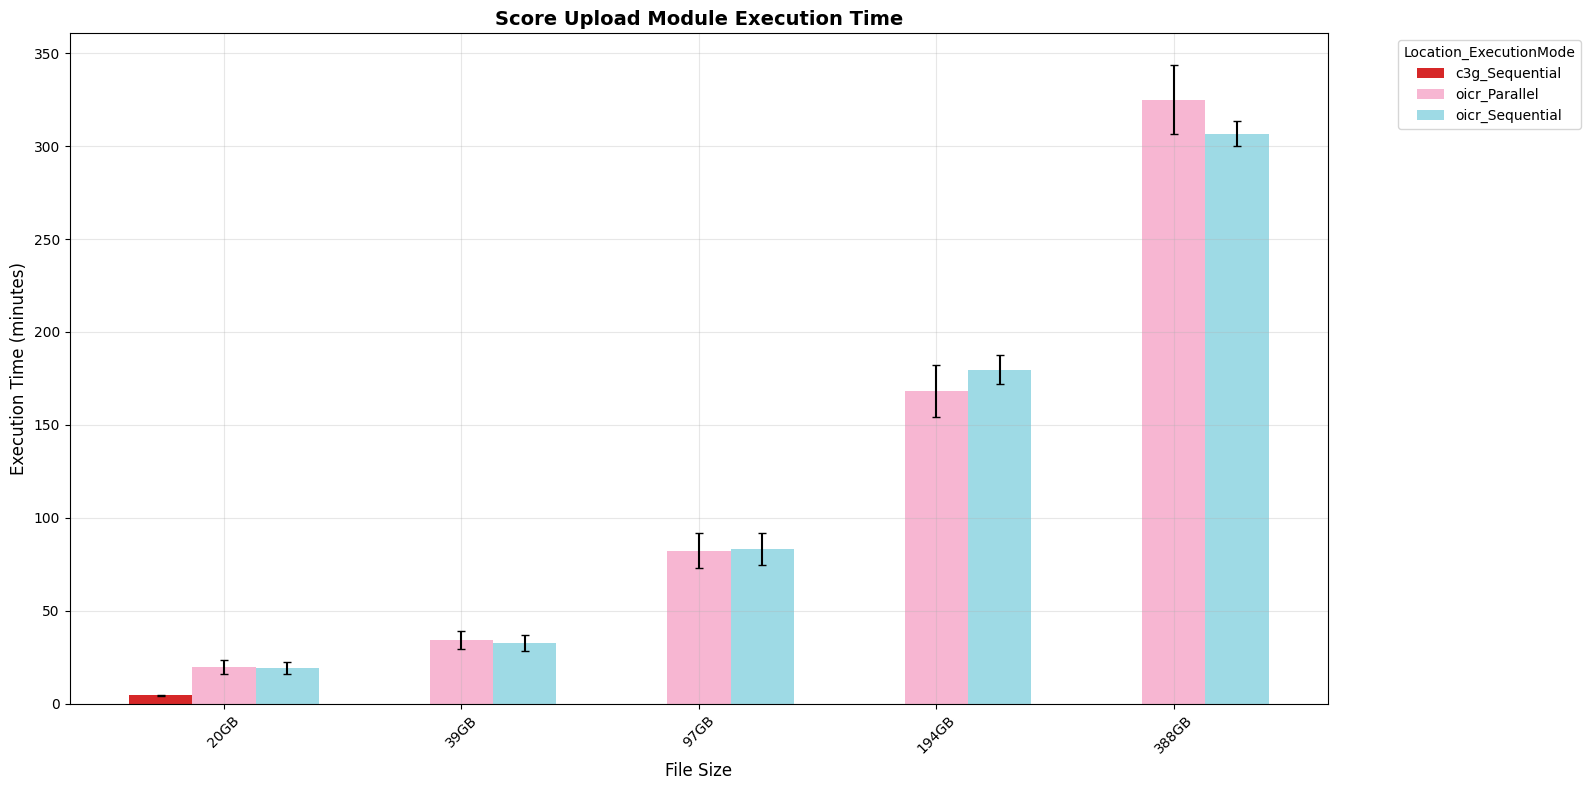

Saved: /Users/lxiang/Projects/PCGL/molecular-data-submission-workflow/tests/performance/analysis_plots/validation_crosscheck_execution_times_consolidated.png


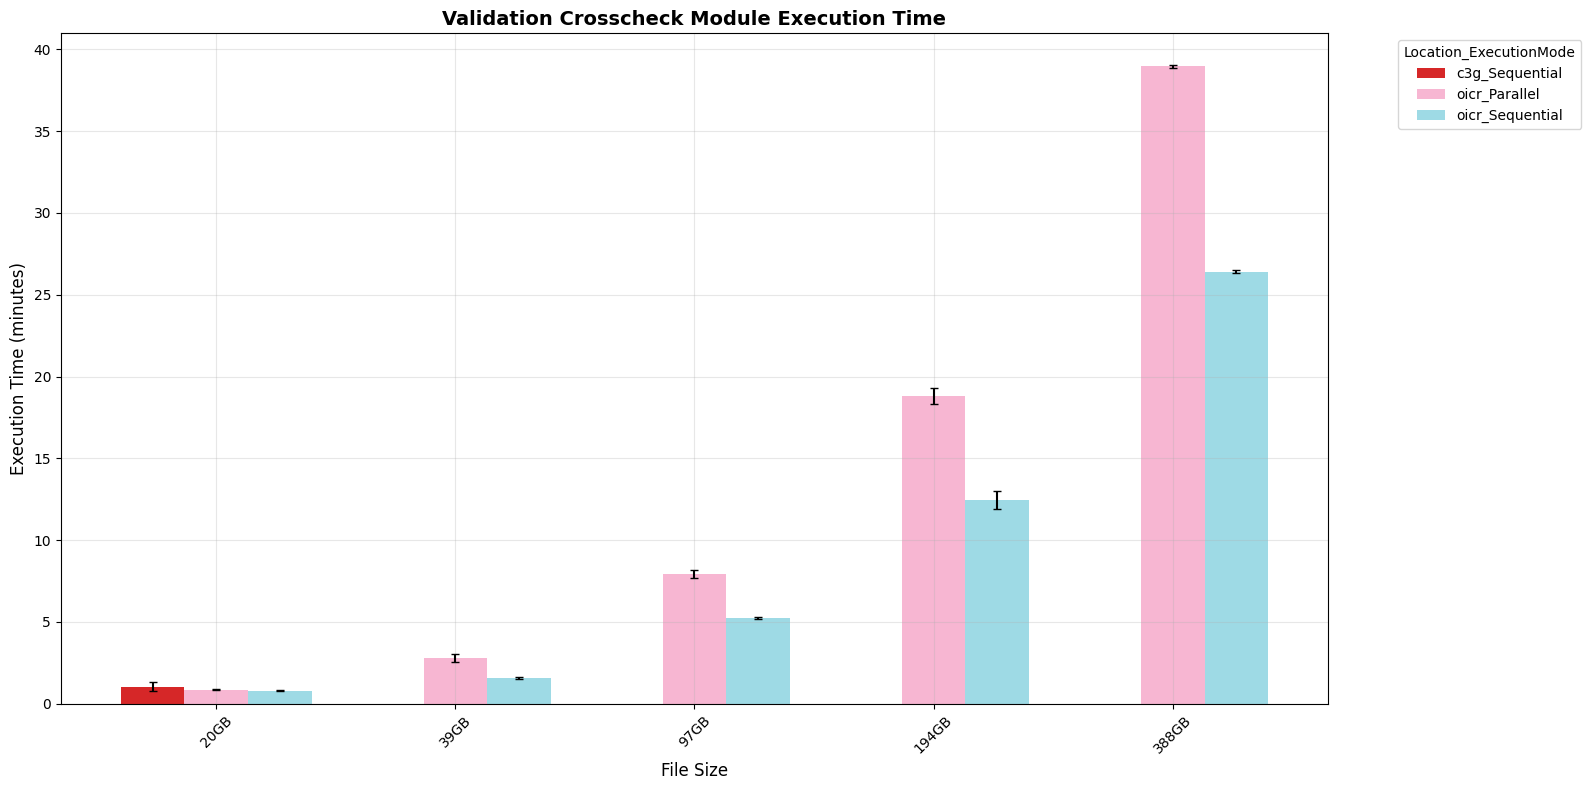

Saved: /Users/lxiang/Projects/PCGL/molecular-data-submission-workflow/tests/performance/analysis_plots/score_upload_process_rates_consolidated.png


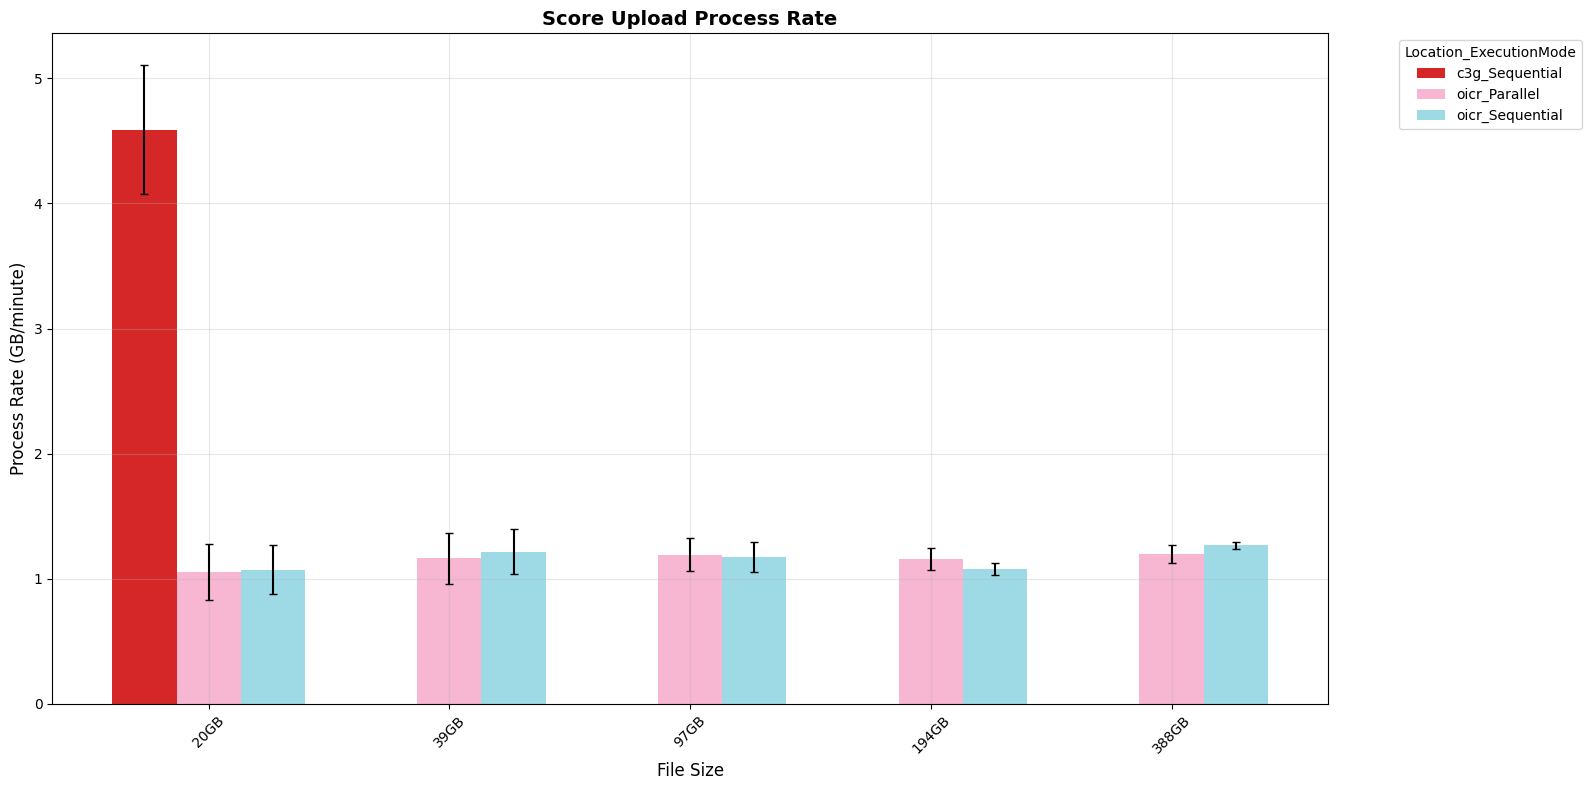

Saved: /Users/lxiang/Projects/PCGL/molecular-data-submission-workflow/tests/performance/analysis_plots/validation_crosscheck_process_rates_consolidated.png


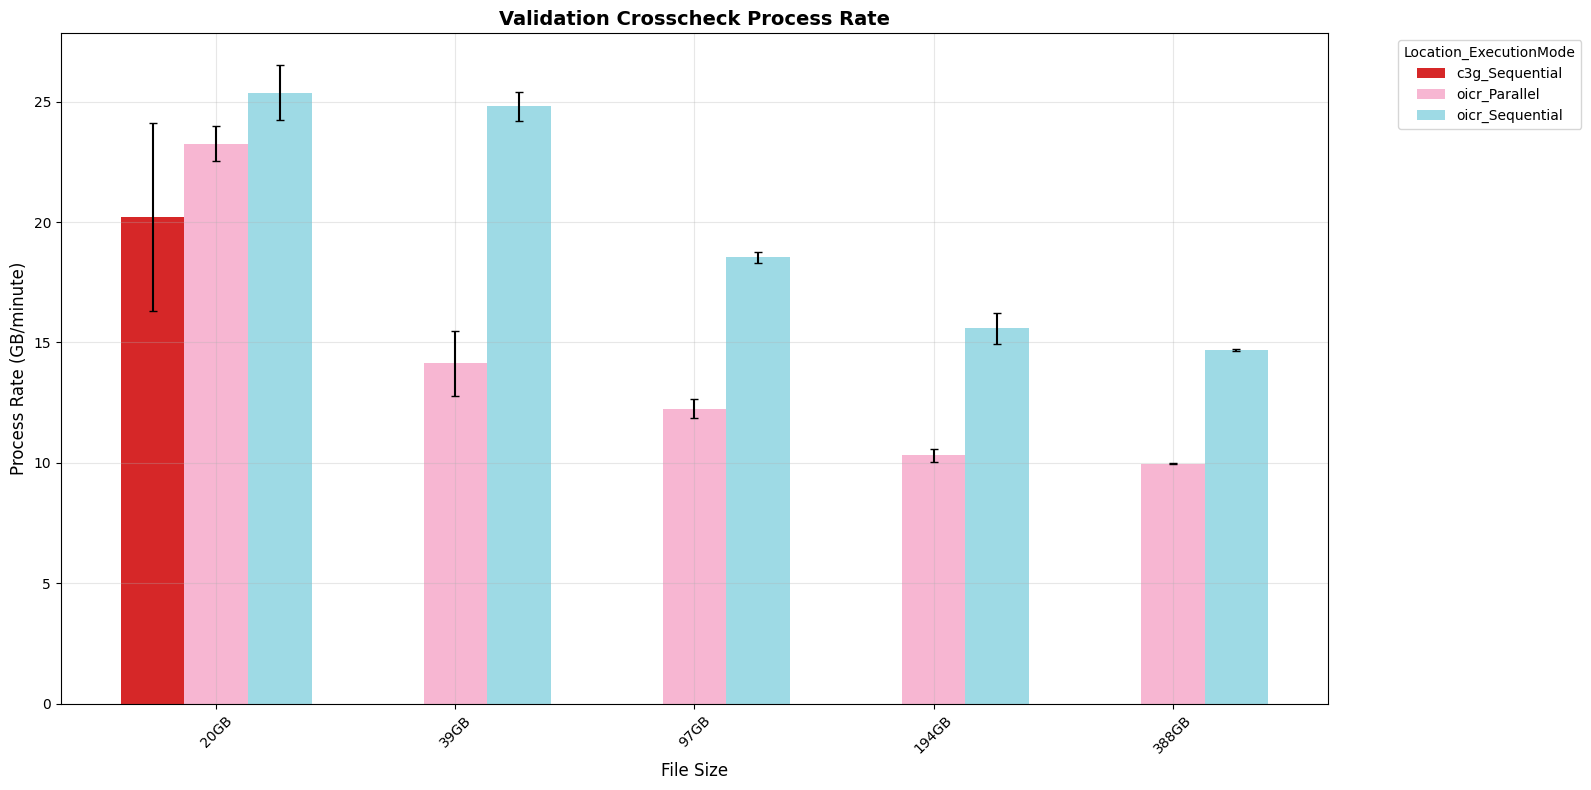

Saved: /Users/lxiang/Projects/PCGL/molecular-data-submission-workflow/tests/performance/analysis_plots/job_duration_consolidated.png


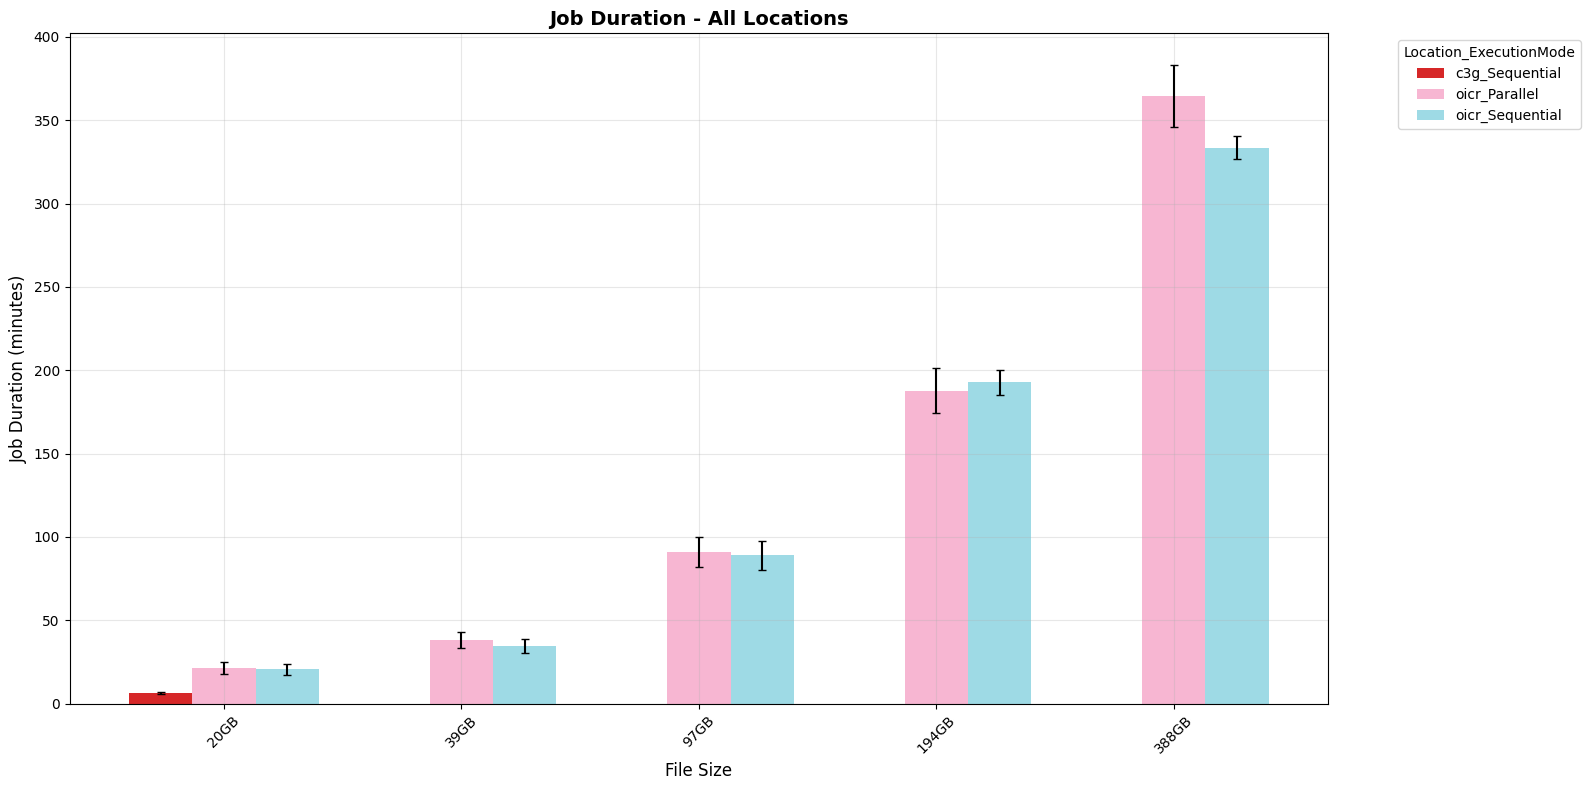

Saved: /Users/lxiang/Projects/PCGL/molecular-data-submission-workflow/tests/performance/analysis_plots/queue_wait_times_consolidated.png


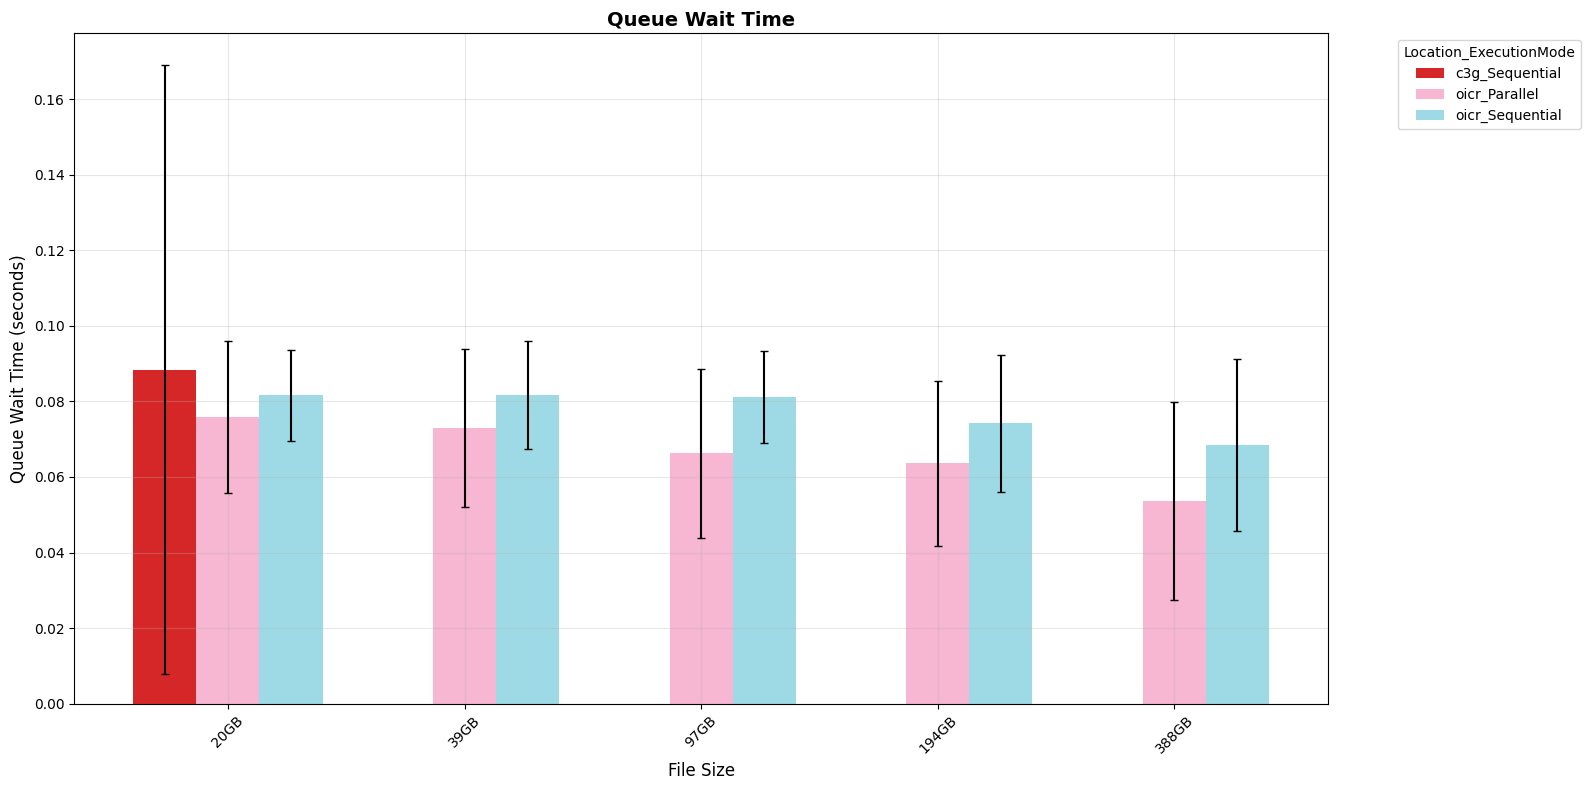


All plots saved to: /Users/lxiang/Projects/PCGL/molecular-data-submission-workflow/tests/performance/analysis_plots


In [19]:
# Generate all comparison plots
if not combined_df.empty and not process_metrics.empty:
    print("Generating performance comparison plots...")
    create_comparison_plots(process_metrics, job_metrics, queue_metrics, output_dir)
    print(f"\nAll plots saved to: {output_dir}")
else:
    print("No data available for plot generation")
    print("Please ensure:")
    print("1. Trace files are available in the input directory")
    print("2. Trace files contain the expected columns (realtime, queue, etc.)")
    print("3. File paths contain file size and execution mode information")

## Summary and Key Findings

### Preliminary Performance Test Results

Based on initial performance analysis from OICR and C3G test environments, the following observations have been identified:

#### 1. Execution Mode Performance Characteristics

**Local Processing Module (Validation Crosscheck):**
- Sequential execution demonstrates superior performance compared to parallel execution
- Performance degradation in parallel mode is likely attributed to resource contention and coordination overhead
- **Recommendation**: Implement maximum parallel execution limits (e.g., `maxForks` parameter) for compute-bound processes to prevent resource contention and optimize throughput

**Data Transfer Module (Score Upload):**
- Minimal performance difference between sequential and parallel execution modes
- Network I/O characteristics are the dominant factor rather than execution strategy

#### 2. Infrastructure Resource Availability

**Queue Wait Time Analysis:**
- Near-zero queue wait times observed across both OICR and C3G infrastructures
- Indicates adequate resource provisioning and minimal scheduling contention in both locations

#### 3. Cross-Location Performance Comparison

**Score Upload Module:**
- **OICR Performance**: Data transfer rate ranges from 1.0 to 1.2 GB/minute (137-164 Mbps)
- **C3G Performance**: Data transfer rate reaches 4.5 GB/minute (614 Mbps)
- C3G demonstrates approximately ~4.5x better throughput compared to OICR. C3G's superior performance is attributed to co-location with object storage infrastructure and premium network transfer capabilities

**Validation Cross Check Module:**
- Comparable performance observed between OICR and C3G locations
- Compute-bound processes demonstrate consistent behavior across test environments

### Next Steps and Recommendations
- **Extended Testing**: Additional test runs from both OICR and C3G locations required to establish statistical significance
- Configure `maxForks` limits for validation_crosscheck and similar CPU-intensive processes

**Note:** Current findings are preliminary and based on limited test data. Conclusions should be validated with additional testing before implementing production-level optimizations.
